In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
fa = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='行业景气度趋势信号',index_col=0)
fb = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='行业拥挤度信号',index_col=0)
fc = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='行业日度超额收益率',index_col=0)
fr = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='行业月度收益率(基金持仓个股，流通市值加权',index_col=0)
wh = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='winda行业权重',index_col=0)
wr = pd.read_excel('行业配置组合优化数据.xlsx',sheet_name='winda月度收益率',index_col=0)

fb = fr.loc[fa.index]
fr = fr.loc[fa.index]
wh = wh.loc[fa.index]
wr = wr.loc[fa.index]

In [3]:
il = set(fa.columns)
n = len(il)

In [30]:
def plot(equity_optimize,equity_winda,name='景气趋势优化'):
    monthly_return = equity_optimize.pct_change()
    winda_return = equity_winda.pct_change()
    excess_return = monthly_return - winda_return
    equity_excess = (excess_return + 1).cumprod()

    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(equity_optimize,label=name)
    plt.plot(equity_winda,label='benchmark')
    plt.plot(equity_excess,label='超额表现')
    plt.legend()
    plt.show()
    print(f"{name}年化收益率={monthly_return.mean() * 12}")
    print(f"{name}年化超额={excess_return.mean() * 12}")
    print(f"{name}最大回撤率={(equity_optimize / equity_optimize.cummax() - 1).min()}")
    print(f"{name}超额最大回撤率={(equity_excess / equity_excess.cummax() - 1).min()}")
    monthly_sharp = monthly_return.mean() / monthly_return.std()
    print(f"{name}年化夏普比率={monthly_sharp * (12 ** 0.5)}")
    print(f"{name}年化信息比率={(monthly_return.mean() - wr.iloc[:,0].mean())* (12 ** 0.5)/ excess_return.std()}")

In [31]:
equity = (fr[1:].mean(axis=1) + 1).cumprod()

In [32]:
equity_winda = (wr.iloc[:,0].fillna(0) + 1).cumprod()

In [33]:
holding_uniform = pd.DataFrame(0.0, index=fa.index, columns=fa.columns)
for i in range(holding_uniform.shape[0]):
    p = fr.iloc[i] + 1
    if i == 0:
        cash = 1
    else:
        cash = (holding_uniform.iloc[i - 1] * p).sum()
    mask = (fa.iloc[i].rank(ascending=False) <= 5)&(fb.iloc[i].rank(ascending=False) > n//4)
    if mask.sum() < 3:
        j = 0
        while mask.sum() < 7:
            mask = (fa.iloc[i].rank(ascending=False) <= 10+j)&(fb.iloc[i].rank(ascending=False) > n//4)
            j += 1
    holding_uniform.iloc[i] = (cash / mask.sum() * mask)
equity_uniform = holding_uniform.sum(axis=1)

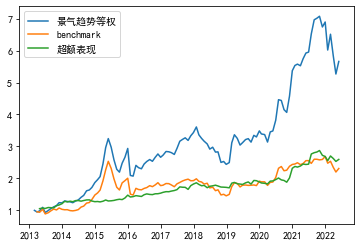

景气趋势等权年化收益率=0.22397875802854067
景气趋势等权年化超额=0.11041589523142223
景气趋势等权最大回撤率=-0.36177523870740946
景气趋势等权超额最大回撤率=-0.11842667697421783
景气趋势等权年化夏普比率=0.8445858301311884
景气趋势等权年化信息比率=1.1783327394920233


In [34]:
plot(equity_uniform,equity,name='景气趋势等权')

In [35]:
def optimize(fa,fc,wh,m,n,x):
    il = set(fa.index)
    d = len(il)
    
    w = cvx.Variable(d)
    full_invest_cons = np.ones((1, d))

    sigma = np.cov(fc.T)
    tracking_error = cvx.quad_form(w, sigma)

    ret = w.T @ fa
    objective = cvx.Maximize(ret)
    constraints = [full_invest_cons @ w == 1, tracking_error <= m, 
                    cvx.norm(w - wh, np.inf) <= n, cvx.norm(w, np.inf) <= x]
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        return w.value
    else:
        print('组合优化无解')
        return [1/d for _ in range(d)]

In [36]:
# warnings.filterwarnings('ignore')
holding_optimize = pd.DataFrame(0.0, index=fa.index, columns=fa.columns)
cp = []
for i in range(holding_optimize.shape[0]):
    r = fr.iloc[i] + 1
    if i == 0:
        cash = 1
    else:
        if (holding_optimize.iloc[i - 1] * r).sum() <= cash:
            cp.append(fr.iloc[i-1].name)
        cash = (holding_optimize.iloc[i - 1] * r).sum()
    mask = fb.iloc[i].rank(ascending=False) > n//4
    signal = (fa.iloc[i].rank(ascending=False) <= 5)&(fb.iloc[i].rank(ascending=False) > n//4)
    if signal.sum() >= 3:
        w = optimize(fa.iloc[i][mask], fc.loc[fc.index<=r.name, mask][-252:], wh.loc[r.name, mask],
                        m=0.2, n=0.25, x=0.35)
    else:
        w = optimize(fa.iloc[i][mask], fc.loc[fc.index<=r.name, mask][-252:], wh.loc[r.name, mask],
                        m=0.1, n=0.15, x=0.25)
    holding_optimize.iloc[i][mask] = cash * w
equity_optimize = holding_optimize.sum(axis=1)

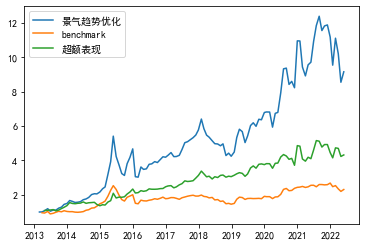

景气趋势优化年化收益率=0.3045535323288316
景气趋势优化年化超额=0.18544261731234155
景气趋势优化最大回撤率=-0.4407881910794865
景气趋势优化超额最大回撤率=-0.1945483744034585
景气趋势优化年化夏普比率=0.8508643998582024
景气趋势优化年化信息比率=0.929481611182563


In [37]:
plot(equity_optimize,equity,name='景气趋势优化')

In [39]:
# for p in cp:
#     signal = (fa.loc[p].rank(ascending=False) <= 5)&(fb.loc[p].rank(ascending=False) > n//4)
#     if signal.sum() >= 3:
#         print(signal.sum())